## build a stock price predictor
## backtesting
## investment portfolio management

In [143]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas_datareader.data as web # fetch stock data

%matplotlib inline

In [334]:
def get_stock_data(symbol, start, end, train_size=0.8):
    '''
    Get stock data in the given date range
    '''
    df = web.DataReader(symbol, 'yahoo', start, end)
    
    train_len = int(df.shape[0] * train_size)
    
    if train_len > 0:
        train_df = df.iloc[:train_len, :]
        test_df = df.iloc[train_len:, :]
        return train_df, test_df
    else:
        return df



In [335]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 1, 1)
train_df, test_df = get_stock_data('AAPL', start, end, 0.8)

In [336]:
# process data

# format stock data, round to 2 decimal place
def format_data(df):
    columns = df.columns
    for col in columns:
        df[col] = df[col].apply(lambda x: round(x,5))
    return df

def get_bollinger_bands(values, window):
    '''
    Return upper and lower Bollinger Bands.
    INPUTS:
    values(pandas series)
    window(int): time period to consider
    OUTPUS:
    upper_band(pandas series)
    lower_band(pandas series)
    '''
    #  rolling mean
    rm = values.rolling(window=window).mean()
    rstd = values.rolling(window=window).std()
    
    band_width = 2. * rstd / rm
    return band_width.apply(lambda x: round(x,5))

def get_adj_close_sma_ratio(values, window):
    '''
    Return the ratio of adjusted closing value to the simple moving average.
    INPUTS:
    values(pandas series)
    window(int): time period to consider
    OUTPUS:
    '''
    rm = values.rolling(window=window).mean()
    ratio = values/rm
    return ratio.apply(lambda x: round(x,5))

def discretize(values, num_states=10):
    '''
    Convert continuous values to integer state
    '''
    states_value = dict()
    step_size = 1./num_states
    for i in range(num_states):
        if i == num_states - 1:
            states_value[i] = values.max()
        else:
            states_value[i] = values.quantile((i+1)*step_size)
    return states_value

def value_to_state(value, states_value):
    # print(states_value)
    if np.isnan(value):
        return np.nan
    else:
        for state, v in states_value.items():
            if value <= v:
                return str(state)
        return 'value out of range'

In [337]:
def create_df(df, window=3):
    # round numbers to 5 decimal place
    
    # normalize close price
    df['norm_adj_close'] = df['Adj Close']/df.iloc[0,:]['Adj Close']
    # get bollinger value
    bb_width = get_bollinger_bands(df['Adj Close'], window)
    # get the ratio of close price to simple moving average
    close_sma_ratio = get_adj_close_sma_ratio(df['Close'], window)
    
    # create bb-width, close-sma-ratio columns
    df['bb_width'] = bb_width
    df['close_sma_ratio'] = close_sma_ratio
    
    return df

train_df = create_df(train_df, 3)
train_df.head()

,High,Low,Open,Close,Volume,Adj Close,norm_adj_close,bb_width,close_sma_ratio
Date,,,,,,,,,
2014-01-02,79.575714,78.860001,79.382858,79.018570,58671200.0,66.964325,1.000000,NaN,NaN
2014-01-03,79.099998,77.204285,78.980003,77.282860,98116900.0,65.493416,0.978034,NaN,NaN
2014-01-06,78.114288,76.228569,76.778572,77.704285,103152700.0,65.850533,0.983367,0.02321,0.99618
2014-01-07,77.994286,76.845711,77.760002,77.148575,79302300.0,65.379593,0.976335,0.00749,0.99703
2014-01-08,77.937141,76.955711,76.972855,77.637146,64632400.0,65.793633,0.982518,0.00783,1.00181


In [338]:
def get_states(df):
    # discretize values
    price_states_value = discretize(df['norm_adj_close'])
    bb_states_value = discretize(df['bb_width'])
    close_sma_ratio_states_value = discretize(df['close_sma_ratio'])
    
    return price_states_value, bb_states_value, close_sma_ratio_states_value

price_states_value, bb_states_value, close_sma_ratio_states_value = get_states(train_df)

In [339]:
price_states_value

{0: 1.1166093473643146,
 1: 1.3325221358919777,
 2: 1.386508066173659,
 3: 1.4734410311868957,
 4: 1.5428881910160337,
 5: 1.5858097641739664,
 6: 1.635467181366886,
 7: 1.7135979705480642,
 8: 1.7797139230191856,
 9: 2.033899166335124}

In [340]:
train_df.shape, test_df.shape

((806, 9), (202, 6))

In [341]:
def create_state_df(df, price_states_value, bb_states_value, close_sma_ratio_states_value):
    # df = format_data(df=df)
    df['bb_width_state'] = df['bb_width'].apply(lambda x : value_to_state(x, bb_states_value))
    df['close_sma_ratio_state'] = df['close_sma_ratio'].apply(lambda x : value_to_state(x, close_sma_ratio_states_value))
    #df['norm_adj_close'] = df['norm_adj_close'].apply(lambda x: round(x,5))
    df['norm_adj_close_state'] = df['norm_adj_close'].apply(lambda x : value_to_state(x, price_states_value))
    
    df['state'] = df['norm_adj_close_state'] + df['close_sma_ratio_state'] + df['bb_width_state']
    df.dropna(inplace=True)
    return df
  
train_df = create_state_df(train_df, price_states_value, bb_states_value, close_sma_ratio_states_value)

train_df.head()

,High,Low,Open,Close,Volume,Adj Close,norm_adj_close,bb_width,close_sma_ratio,bb_width_state,close_sma_ratio_state,norm_adj_close_state,state
Date,,,,,,,,,,,,,
2014-01-06,78.114288,76.228569,76.778572,77.704285,103152700.0,65.850533,0.983367,0.02321,0.99618,7,2,0,027
2014-01-07,77.994286,76.845711,77.760002,77.148575,79302300.0,65.379593,0.976335,0.00749,0.99703,1,3,0,031
2014-01-08,77.937141,76.955711,76.972855,77.637146,64632400.0,65.793633,0.982518,0.00783,1.00181,2,5,0,052
2014-01-09,78.122856,76.478569,78.114288,76.645714,69787200.0,64.953445,0.969971,0.01285,0.99354,4,1,0,014
2014-01-10,77.257141,75.872856,77.118568,76.134285,76244000.0,64.520035,0.963499,0.01990,0.99126,6,1,0,016


In [342]:
train_df[train_df.state=='value out of range73']

,High,Low,Open,Close,Volume,Adj Close,norm_adj_close,bb_width,close_sma_ratio,bb_width_state,close_sma_ratio_state,norm_adj_close_state,state
Date,,,,,,,,,,,,,


In [343]:
def get_all_states(price_states_value, bb_states_value, close_sma_ratio_states_value):
    states = []
    
    for p, _ in price_states_value.items():
        for c, _ in close_sma_ratio_states_value.items():
            for b, _ in bb_states_value.items():
                state =  str(p) + str(c) + str(b)
                states.append(str(state))
    
    return states

all_states = get_all_states(price_states_value, bb_states_value, close_sma_ratio_states_value)
states_size = len(all_states)

In [344]:
all_actions = {0:'hold', 1:'buy', 2:'sell'}

In [345]:
def initialize_q_mat(all_states, all_actions):
    states_size = len(all_states)
    actions_size = len(all_actions)
    
    q_mat = np.random.rand(states_size, actions_size)
    q_mat = pd.DataFrame(q_mat, columns=all_actions.keys())
    
    q_mat['states'] = all_states
    q_mat.set_index('states', inplace=True)
    
    return q_mat

In [346]:
def act(state, q_mat, threshold=0.2, actions_size=3):
    # decide to go random or pick max
    if np.random.uniform(0,1) < threshold: # go random
        action = np.random.randint(low=0, high=actions_size)
        print('random choice: {}'.format(all_actions[action]))
    else:
        action = np.argmax(q_mat.loc[state].values)
        print('max choice: {}'.format(all_actions[action])
             )
    return action

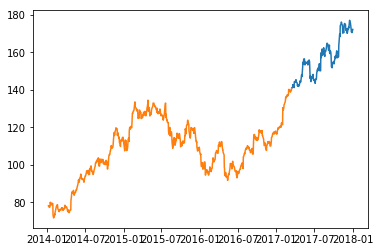

In [347]:
plt.plot(test_df['High']);
plt.plot(train_df['High']);

In [348]:
def get_return_since_entry(bought_history, current_adj_close, current_day):
    '''
    Calculate the returns of current share holdings.
    INPUTS:
    bought_history(list) 
    current_adj_close(float)
    current_day(int)
    OUTPUTS:
    return_since_entry(float)
    '''
    return_since_entry = 0.
    
    for day, b in bought_history:
        return_since_entry += (current_adj_close - b)
    return return_since_entry

In [349]:
# process test df
test_df = create_df(test_df, 3)
test_df.head()

,High,Low,Open,Close,Volume,Adj Close,norm_adj_close,bb_width,close_sma_ratio
Date,,,,,,,,,
2017-03-16,141.020004,140.259995,140.720001,140.690002,19232000.0,136.421692,1.000000,NaN,NaN
2017-03-17,141.000000,139.889999,141.000000,139.990005,43885000.0,135.742950,0.995025,NaN,NaN
2017-03-20,141.500000,140.229996,140.399994,141.460007,21542000.0,137.168365,1.005473,0.01045,1.00531
2017-03-21,142.800003,139.729996,142.110001,139.839996,39529900.0,135.597504,0.993959,0.01275,0.99580
2017-03-22,141.600006,139.759995,139.850006,141.419998,25860200.0,137.129562,1.005189,0.01311,1.00364


In [350]:
test_df = create_state_df(test_df, price_states_value, bb_states_value, close_sma_ratio_states_value)
test_df.state.unique()

array(['073', '024', '064', '053', '031', '040', '097', '087', '030',
       '062', '032', '022', '014', '033', '051', '074', '075', '041',
       '021', '085', '099', '098', '052', '054', '009', '038', '076',
       '072', '050', '086', '034', '037', '023', '015', '016', '058',
       '042', '065', '025', '063', '061', '017', '199', '089', '043',
       '186', '187', '174', '008', '138', '198', '143', '107', '117',
       '130', '185', '176', '140', '163', '161', '150', '114', '124',
       '131', '116', '156', '113', '115', '133', '132', '151', '197',
       '108', '125', '144', '173', '152', '121', '164', '123', '154',
       '196', '141', '134', '118', '175'], dtype=object)

In [351]:
q = initialize_q_mat(all_states, all_actions)/1e8
print('starting q')
print(q)

starting q
                   0             1             2
states                                          
000     4.415643e-09  1.350845e-09  5.075140e-09
001     9.507087e-09  8.267349e-09  7.272131e-09
002     3.650454e-09  5.197423e-10  2.682305e-09
003     7.832983e-09  2.660130e-09  7.699111e-09
004     6.831545e-09  7.082385e-10  8.397294e-09
005     5.818358e-09  2.377512e-11  2.086670e-09
006     4.464303e-09  8.277504e-09  4.448693e-09
007     1.378710e-09  2.991228e-09  6.517705e-09
008     1.219175e-09  8.813592e-09  4.993984e-09
009     5.680318e-09  7.683456e-09  1.985570e-09
010     9.348842e-09  1.732089e-10  6.735318e-09
011     9.441613e-09  6.878461e-09  7.596710e-09
012     5.621667e-09  7.717320e-10  2.645469e-09
013     9.600868e-09  5.008628e-09  2.420871e-09
014     4.130003e-09  4.288953e-09  1.407387e-09
015     6.009320e-09  2.634795e-09  9.835325e-09
016     5.896296e-09  9.250116e-09  4.802425e-09
017     5.356798e-09  9.480496e-09  7.528570e-09
018     1

In [353]:
cntr = 0

train_data = np.array(train_df[['Adj Close', 'state']])

actions_history = []

num_shares = 0
alpha = 0.2
gamma = 0.95 # discount_rate
bought_history = [] # (day,price)
returns_since_entry = [0]
days = [0]


for i, val in enumerate(train_data):
    current_adj_close, state = val
    try:
        next_adj_close, next_state = train_data[i+1]
    except:
        print('End of data! Done!')
        break

    print('day {}，current state {}, '.format(i, state), end=' ') #i, state, next_state
    
    if len(bought_history) > 0:
        returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close, i)) 
    else:
        returns_since_entry.append(returns_since_entry[-1])
    print('return since entry {}'.format(returns_since_entry[-1]))


    # decide action
    action = act(state, q, threshold=0.3/(i+1), actions_size=3)

    # get reward
    if action == 0: # hold
        if num_shares > 0:
            reward = next_adj_close - current_adj_close            
        else:
            reward = 0

    if action == 1: # buy
        reward = 0
        num_shares += 1
        bought_history.append((i, current_adj_close))
        print('at price {}'.format(current_adj_close))

    if action == 2: # sell
        if num_shares > 0:
            bought_price = bought_history[0][1]
            bought_history.pop(0)
            reward = current_adj_close - bought_price

            num_shares -= 1
            print('at price {}'.format(current_adj_close))
        else:
            reward = -1
    actions_history.append((i, current_adj_close, action))
    # update q table

    q.loc[state, action] = (1.-alpha)*q.loc[state, action] + alpha*(reward+gamma*(q.loc[next_state].max()))

#     cntr += 1
#     if cntr ==40:
#         break


day 0，current state 027,  return since entry 0
max choice: buy
at price 65.85053253173828
day 1，current state 031,  return since entry -0.47093963623046875
max choice: hold
day 2，current state 052,  return since entry -0.0569000244140625
random choice: sell
at price 65.79363250732422
day 3，current state 014,  return since entry -0.0569000244140625
max choice: buy
at price 64.95344543457031
day 4，current state 016,  return since entry -0.43341064453125
max choice: buy
at price 64.52003479003906
day 5，current state 051,  return since entry 0.242156982421875
max choice: buy
at price 64.85781860351562
day 6，current state 097,  return since entry 4.11383056640625
max choice: sell
at price 66.14837646484375
day 7，current state 099,  return since entry 5.574981689453125
max choice: buy
at price 67.4764175415039
day 8，current state 056,  return since entry 4.44549560546875
max choice: sell
at price 67.09992218017578
day 9，current state 008,  return since entry -1.4224777221679688
max choice: b

day 245，current state 522,  return since entry 458.3206329345703
max choice: sell
at price 104.0169448852539
day 246，current state 585,  return since entry 563.6063232421875
max choice: sell
at price 105.85565185546875
day 247，current state 576,  return since entry 540.4375381469727
max choice: sell
at price 105.78136444091797
day 248，current state 514,  return since entry 439.41268157958984
max choice: sell
at price 104.49055480957031
day 249，current state 408,  return since entry 299.6339569091797
max choice: sell
at price 102.50326538085938
day 250，current state 408,  return since entry 226.8275146484375
max choice: sell
at price 101.52819061279297
day 251，current state 309,  return since entry 41.42201232910156
max choice: buy
at price 98.66798400878906
day 252，current state 418,  return since entry 41.99720764160156
max choice: hold
day 253，current state 485,  return since entry 127.7850341796875
max choice: sell
at price 100.0609359741211
day 254，current state 599,  return since 

day 439，current state 552,  return since entry -761.1254730224609
max choice: hold
day 440，current state 563,  return since entry -732.5373382568359
max choice: buy
at price 104.18157958984375
day 441，current state 562,  return since entry -694.1589431762695
max choice: buy
at price 104.68000030517578
day 442，current state 531,  return since entry -733.035758972168
max choice: buy
at price 104.18157958984375
day 443，current state 415,  return since entry -828.1320571899414
max choice: hold
day 444，current state 587,  return since entry -633.4811248779297
max choice: buy
at price 105.44176483154297
day 445，current state 567,  return since entry -672.6028289794922
max choice: hold
day 446，current state 540,  return since entry -658.3090057373047
max choice: buy
at price 105.13141632080078
day 447，current state 515,  return since entry -778.6657409667969
max choice: hold
day 448，current state 565,  return since entry -652.976448059082
max choice: sell
at price 105.19725036621094
day 449，c

max choice: buy
at price 95.9285659790039
day 603，current state 352,  return since entry -1238.0121765136719
max choice: sell
at price 95.8712387084961
day 604，current state 321,  return since entry -1287.5911102294922
max choice: buy
at price 95.40312194824219
day 605，current state 316,  return since entry -1501.5950164794922
max choice: buy
at price 94.06559753417969
day 606，current state 316,  return since entry -1615.4147644042969
max choice: buy
at price 93.358642578125
day 607，current state 332,  return since entry -1584.4625701904297
max choice: hold
day 608，current state 373,  return since entry -1474.578140258789
max choice: buy
at price 94.2280044555664
day 609，current state 363,  return since entry -1412.2866516113281
max choice: sell
at price 94.61016082763672
day 610，current state 340,  return since entry -1398.9410934448242
max choice: buy
at price 94.52418518066406
day 611，current state 362,  return since entry -1288.3771209716797
max choice: sell
at price 95.20249176025

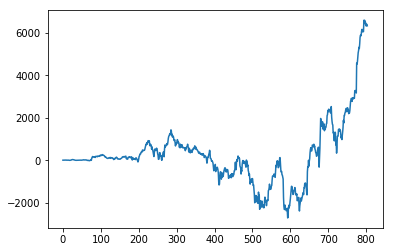

In [354]:
plt.plot(returns_since_entry)

In [355]:
test_df.head()

,High,Low,Open,Close,Volume,Adj Close,norm_adj_close,bb_width,close_sma_ratio,bb_width_state,close_sma_ratio_state,norm_adj_close_state,state
Date,,,,,,,,,,,,,
2017-03-20,141.500000,140.229996,140.399994,141.460007,21542000.0,137.168365,1.005473,0.01045,1.00531,3,7,0,073
2017-03-21,142.800003,139.729996,142.110001,139.839996,39529900.0,135.597504,0.993959,0.01275,0.99580,4,2,0,024
2017-03-22,141.600006,139.759995,139.850006,141.419998,25860200.0,137.129562,1.005189,0.01311,1.00364,4,6,0,064
2017-03-23,141.580002,140.610001,141.259995,140.919998,20346300.0,136.644714,1.001635,0.01148,1.00137,3,5,0,053
2017-03-24,141.740005,140.350006,141.500000,140.639999,22395600.0,136.373230,0.999645,0.00561,0.99749,1,3,0,031


In [357]:
cntr = 0

# all_data = np.array(f[['Adj Close', 'state']])

actions_history = []

num_shares = 0
alpha = 0.2
gamma = 0.95 # discount_rate
bought_history = [] # (day,price)
returns_since_entry = [0]
days = [0]

test_data = np.array(test_df[['Adj Close', 'state']])

for i, val in enumerate(test_data):
    current_adj_close, state = val
    try:
        next_adj_close, next_state = test_data[i+1]
    except:
        print('End of data! Done!')
        break

    print('day {}，current state {}, '.format(i, state), end=' ') #i, state, next_state
    
    if len(bought_history) > 0:
        returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close, i)) 
    else:
        returns_since_entry.append(returns_since_entry[-1])
    print('return since entry {}'.format(returns_since_entry[-1]))


    # decide action
    action = act(state, q, threshold=0, actions_size=3)

    # get reward
    if action == 0: # hold
        if num_shares > 0:
            reward = next_adj_close - current_adj_close            
        else:
            reward = 0

    if action == 1: # buy
        reward = 0
        num_shares += 1
        bought_history.append((i, current_adj_close))
        print('at price {}'.format(current_adj_close))

    if action == 2: # sell
        if num_shares > 0:
            bought_price = bought_history[0][1]
            bought_history.pop(0)
            reward = current_adj_close - bought_price

            num_shares -= 1
            print('at price {}'.format(current_adj_close))
        else:
            reward = -1
    actions_history.append((i, current_adj_close, action))



day 0，current state 073,  return since entry 0
max choice: sell
day 1，current state 024,  return since entry 0
max choice: buy
at price 135.59750366210938
day 2，current state 064,  return since entry 1.5320587158203125
max choice: sell
at price 137.1295623779297
day 3，current state 053,  return since entry 1.5320587158203125
max choice: buy
at price 136.64471435546875
day 4，current state 031,  return since entry -0.271484375
max choice: hold
day 5，current state 040,  return since entry -0.03875732421875
max choice: sell
at price 136.60595703125
day 6，current state 097,  return since entry -0.03875732421875
max choice: sell
day 7，current state 087,  return since entry -0.03875732421875
max choice: buy
at price 139.74765014648438
day 8，current state 040,  return since entry -0.184234619140625
max choice: sell
at price 139.56341552734375
day 9，current state 030,  return since entry -0.184234619140625
max choice: buy
at price 139.30160522460938
day 10，current state 040,  return since entry

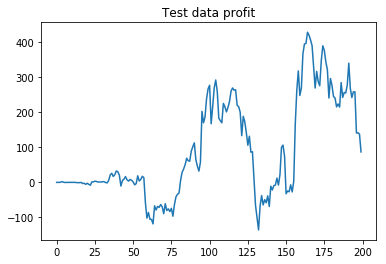

In [358]:
plt.plot(returns_since_entry);
plt.title('Test data profit');

In [362]:
start = datetime.datetime(2017, 9, 1)
end = datetime.datetime(2017, 10, 1)
amazon_df = get_stock_data('GOOG', start, end, train_size=0)
amazon_df = create_df(amazon_df, 3)
amazon_df = create_state_df(amazon_df, price_states_value, bb_states_value, close_sma_ratio_states_value)

In [363]:
amazon_df

,High,Low,Open,Close,Volume,Adj Close,norm_adj_close,bb_width,close_sma_ratio,bb_width_state,close_sma_ratio_state,norm_adj_close_state,state
Date,,,,,,,,,,,,,
2017-09-06,930.914978,919.270020,930.150024,927.809998,1527700,927.809998,0.989833,0.01144,0.99636,3,2,0,023
2017-09-07,936.409973,923.619995,931.729980,935.950012,1212700,935.950012,0.998517,0.00973,1.00560,3,7,0,073
2017-09-08,936.989990,924.880005,936.489990,926.500000,1011500,926.500000,0.988435,0.01101,0.99614,3,2,0,023
2017-09-11,938.380005,926.919983,934.250000,929.080017,1267000,929.080017,0.991188,0.01050,0.99846,3,3,0,033
2017-09-12,933.479980,923.861023,932.590027,932.070007,1134400,932.070007,0.994378,0.00600,1.00307,1,5,0,051
2017-09-13,937.250000,929.859985,930.659973,935.090027,1102600,935.090027,0.997600,0.00645,1.00323,1,5,0,051
2017-09-14,932.770020,924.000000,931.250000,925.109985,1397600,925.109985,0.986952,0.01100,0.99393,3,1,0,013
2017-09-15,926.489990,916.359985,924.659973,920.289978,2505400,920.289978,0.981810,0.01629,0.99294,5,1,0,015
2017-09-18,922.080017,910.599976,920.010010,915.000000,1306900,915.000000,0.976167,0.01099,0.99442,3,2,0,023


day 0，current state 023,  return since entry 0
max choice: sell
day 1，current state 073,  return since entry 0
max choice: sell
day 2，current state 023,  return since entry 0
max choice: sell
day 3，current state 033,  return since entry 0
max choice: buy
at price 929.0800170898438
day 4，current state 051,  return since entry 2.989990234375
max choice: buy
at price 932.0700073242188
day 5，current state 051,  return since entry 9.030029296875
max choice: buy
at price 935.0900268554688
day 6，current state 013,  return since entry -20.91009521484375
max choice: hold
day 7，current state 015,  return since entry -35.3701171875
max choice: sell
at price 920.2899780273438
day 8，current state 023,  return since entry -37.1600341796875
max choice: sell
at price 915.0
day 9，current state 052,  return since entry -13.280029296875
max choice: buy
at price 921.8099975585938
day 10，current state 085,  return since entry 6.260009765625
max choice: buy
at price 931.5800170898438
day 11，current state 06

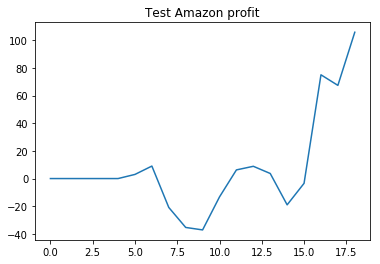

In [364]:
cntr = 0

# all_data = np.array(f[['Adj Close', 'state']])

actions_history = []

num_shares = 0
alpha = 0.2
gamma = 0.95 # discount_rate
bought_history = [] # (day,price)
returns_since_entry = [0]
days = [0]

test_data = np.array(amazon_df[['Adj Close', 'state']])

for i, val in enumerate(test_data):
    current_adj_close, state = val
    try:
        next_adj_close, next_state = test_data[i+1]
    except:
        print('End of data! Done!')
        break

    print('day {}，current state {}, '.format(i, state), end=' ') #i, state, next_state
    
    if len(bought_history) > 0:
        returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close, i)) 
    else:
        returns_since_entry.append(returns_since_entry[-1])
    print('return since entry {}'.format(returns_since_entry[-1]))


    # decide action
    action = act(state, q, threshold=0, actions_size=3)

    # get reward
    if action == 0: # hold
        if num_shares > 0:
            reward = next_adj_close - current_adj_close            
        else:
            reward = 0

    if action == 1: # buy
        reward = 0
        num_shares += 1
        bought_history.append((i, current_adj_close))
        print('at price {}'.format(current_adj_close))

    if action == 2: # sell
        if num_shares > 0:
            bought_price = bought_history[0][1]
            bought_history.pop(0)
            reward = current_adj_close - bought_price

            num_shares -= 1
            print('at price {}'.format(current_adj_close))
        else:
            reward = -1
    actions_history.append((i, current_adj_close, action))

plt.plot(returns_since_entry);
plt.title('Test Amazon profit');
